# Natural Language Processing Milestone 1

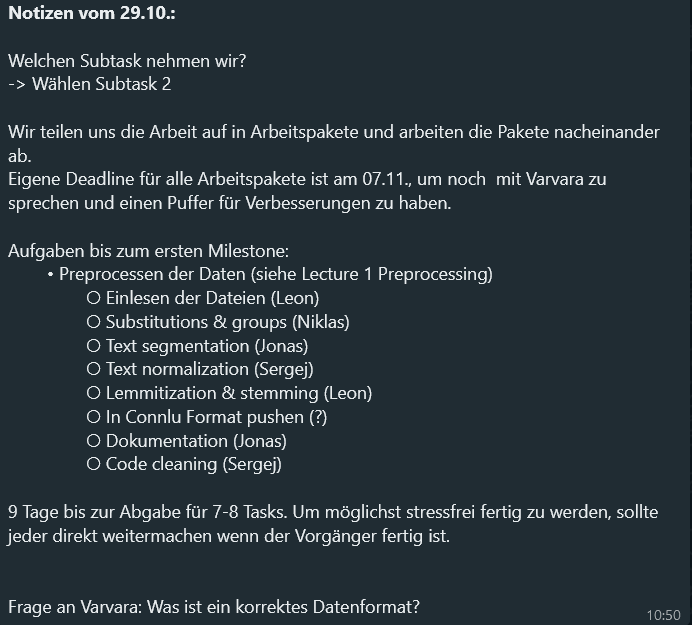

## Content

- Data Prep (Leon)
    - Create a dataframe that contains the file contents and labels (make data-label pairs)
    - Create taxonomy dataframes to map labels to numerical indices
    - Map the dataset to the taxonomies and create a numerical column that classifies an article
- ...

## Data Prep

**Uncertainties:**

- Is the current way of handling whether an article is UA or CC sensible?
- The proper numerical representation of the labels is questionable. Should the hierarchical structure somehow be kept? Is One-Hot-Encoding sensible?
- The two different taxonomies for the two topics lead to the question whether two different models should be trained, one for the ukraine war and one for climate change.

### Creating a first dataframe containing [filename, content, label, topic] for each datapoint

The documents belong to two different topics, ukraine war and climate change. We will show which topic each document belongs to by adding the column "topic", which is based on the abbreviations UA or CC in the document filenames.

In [41]:
%pip install --requirement requirements.txt
# When you import something new that is not in the requirements.txt file, please add it to the requirements.txt file and re-run the cell above.


import os
import pandas as pd
import fitz  # PyMuPDF
from nltk.corpus import stopwords
import re

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:


# Define the paths
documents_path = "../training_data_16_October_release/EN/raw-documents"
annotations_file = "../training_data_16_October_release/EN/subtask-2-annotations.txt"

# Read the annotations file
annotations = pd.read_csv(annotations_file, sep='\t', header=None, names=['filename', 'narrative', 'subnarrative'])

# Remove all occurrences of "CC: " and "URW: " from narratives and subnarratives
annotations['narrative'] = annotations['narrative'].str.replace(r'(CC: |URW: )', '', regex=True)
annotations['subnarrative'] = annotations['subnarrative'].str.replace(r'(CC: |URW: )', '', regex=True)

# Split the narratives and subnarratives into lists
annotations['narrative'] = annotations['narrative'].str.split(';')
annotations['subnarrative'] = annotations['subnarrative'].str.split(';')

# Initialize a list to store the data
data = []

# Iterate over the annotations and read the corresponding documents
for _, row in annotations.iterrows():
    filename = row['filename']
    narratives = row['narrative']
    subnarratives = row['subnarrative']
    
    # Read the document content
    with open(os.path.join(documents_path, filename), 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Determine the topic based on the filename
    topic = "UA" if "UA" in filename else "CC"
    
    # Append the document content, narratives, subnarratives, and topic to the data list
    data.append({
        'filename': filename,
        'content': content,
        'narratives': narratives,
        'subnarratives': subnarratives,
        'topic': topic
    })

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,filename,content,narratives,subnarratives,topic
0,EN_UA_103861.txt,The World Needs Peacemaker Trump Again \n\n by...,[Other],[Other],UA
1,EN_UA_103667.txt,Desperation and Diplomacy: North Korea's Tech ...,[Other],[Other],UA
2,EN_UA_021270.txt,"Ukraine's Fate Will Be Decided In Coming Year,...","[Speculating war outcomes, Discrediting Ukrain...","[Speculating war outcomes: Other, Discrediting...",UA
3,EN_UA_103403.txt,Russia Stages Major Airstrike on Ukraine; One ...,[Other],[Other],UA
4,EN_CC_100145.txt,Strategy needed to preserve water resources in...,[Other],[Other],CC


The narratives row seems to be redundant, since the subnarrative row is structured in the way *narrative:subnarrative*. To check whether this is the case for all labels, we use the following function before removing the redundancy.

In [3]:
def check_pattern(row):
    narratives = row['narratives']
    subnarratives = row['subnarratives']
    
    for narrative, subnarrative in zip(narratives, subnarratives):
        if not subnarrative.startswith(narrative + ":"):
            return (row.name, narrative, subnarrative)
    return None

# Apply the function to each row and collect the results
pattern_check_results = df.apply(check_pattern, axis=1)

# Filter out the rows where the pattern does not hold
problematic_rows = pattern_check_results[pattern_check_results.notnull()]

# Set display options to avoid truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Display the problematic rows
print("Problematic rows where the pattern does not hold:")
print(problematic_rows)

Problematic rows where the pattern does not hold:
0        (0, Other, Other)
1        (1, Other, Other)
3        (3, Other, Other)
4        (4, Other, Other)
5        (5, Other, Other)
7        (7, Other, Other)
9        (9, Other, Other)
10      (10, Other, Other)
16      (16, Other, Other)
17      (17, Other, Other)
19      (19, Other, Other)
20      (20, Other, Other)
21      (21, Other, Other)
23      (23, Other, Other)
27      (27, Other, Other)
28      (28, Other, Other)
30      (30, Other, Other)
32      (32, Other, Other)
33      (33, Other, Other)
34      (34, Other, Other)
35      (35, Other, Other)
37      (37, Other, Other)
39      (39, Other, Other)
42      (42, Other, Other)
44      (44, Other, Other)
45      (45, Other, Other)
48      (48, Other, Other)
49      (49, Other, Other)
50      (50, Other, Other)
51      (51, Other, Other)
52      (52, Other, Other)
53      (53, Other, Other)
56      (56, Other, Other)
60      (60, Other, Other)
63      (63, Other, Other)
64   

Since the only exception from the pattern seems to be *narrative other, subnarrative other* cases, we can delete the narratives before the ":" in the subnarratives column.

In [4]:
def remove_redundant_narratives(row):
    narratives = row['narratives']
    subnarratives = row['subnarratives']
    
    cleaned_subnarratives = []
    for narrative, subnarrative in zip(narratives, subnarratives):
        if subnarrative.startswith(narrative + ":"):
            cleaned_subnarrative = subnarrative[len(narrative) + 1:].strip()
            cleaned_subnarratives.append(cleaned_subnarrative)
        else:
            cleaned_subnarratives.append(subnarrative)
    
    return cleaned_subnarratives

# Apply the function to each row to clean the subnarratives
df['subnarratives'] = df.apply(remove_redundant_narratives, axis=1)

# Display the updated DataFrame
print("Updated DataFrame with cleaned subnarratives:")
df.head()

Updated DataFrame with cleaned subnarratives:


filename  \
0  EN_UA_103861.txt   
1  EN_UA_103667.txt   
2  EN_UA_021270.txt   
3  EN_UA_103403.txt   
4  EN_CC_100145.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [5]:
def create_narrative_subnarrative_pairs(row):
    narratives = row['narratives']
    subnarratives = row['subnarratives']
    
    pairs = []
    for narrative, subnarrative in zip(narratives, subnarratives):
        if subnarrative.startswith(narrative + ":"):
            cleaned_subnarrative = subnarrative[len(narrative) + 1:].strip()
        else:
            cleaned_subnarrative = subnarrative
        pairs.append({'narrative': narrative, 'subnarrative': cleaned_subnarrative})
    
    return pairs

# Apply the function to each row to create narrative-subnarrative pairs
df['narrative_subnarrative_pairs'] = df.apply(create_narrative_subnarrative_pairs, axis=1)

# Drop the original narratives and subnarratives columns if no longer needed
df = df.drop(columns=['narratives', 'subnarratives'])

# Display the updated DataFrame
print("Updated DataFrame with narrative-subnarrative pairs:")
df.head()

Updated DataFrame with narrative-subnarrative pairs:


filename  \
0  EN_UA_103861.txt   
1  EN_UA_103667.txt   
2  EN_UA_021270.txt   
3  EN_UA_103403.txt   
4  EN_CC_100145.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Extract the label taxonomy

Here we create a templete for each label taxonomy (for each of the two topics) from the subtask 2 pdf file. We can use this to encode the labels of the datapoints in the dataset. We do this by assigning an index to every possible class (narrative-subnarrative pair) that we can use to numerically classify the articles.

In [ ]:

# Define the path to the PDF file
pdf_path = "../info/subtask2_NARRATIVE-TAXONOMIES.pdf"

# Open the PDF file
pdf_document = fitz.open(pdf_path)

# Function to extract text from a specific page
def extract_text_from_page(page_number):
    page = pdf_document.load_page(page_number)
    text = page.get_text("text")
    return text

# Extract text from the relevant pages
ukraine_war_text = extract_text_from_page(0)  # Assuming the first page contains Ukraine War taxonomy
climate_change_text = extract_text_from_page(1)  # Assuming the second page contains Climate Change taxonomy

# Function to parse the taxonomy text and create a DataFrame
def parse_taxonomy(text):
    lines = text.split('\n')
    # Exclude the last two lines
    lines = lines[:-3]
    data = []
    current_narrative = None
    for line in lines:
        if line.strip() == "":
            continue
        if line.startswith("-"):  # Subnarrative
            subnarrative = line.strip("- ").strip()
            data.append({'narrative': current_narrative, 'subnarrative': subnarrative})
        else:  # Narrative
            if current_narrative and not any(d['narrative'] == current_narrative for d in data):
                # Add the narrative itself as subnarrative if it has no subnarratives
                data.append({'narrative': current_narrative, 'subnarrative': current_narrative})
            current_narrative = line.strip()
            if current_narrative == "Other":
                data.append({'narrative': "Other", 'subnarrative': "Other"})
    # Handle the last narrative if it has no subnarratives
    if current_narrative and not any(d['narrative'] == current_narrative for d in data):
        data.append({'narrative': current_narrative, 'subnarrative': 'Other'})
    
    df = pd.DataFrame(data)
    df = df.sort_values(by='narrative', ascending=True).reset_index(drop=True)
    return df

# Parse the taxonomies and create DataFrames
ukraine_war_df = parse_taxonomy(ukraine_war_text)
climate_change_df = parse_taxonomy(climate_change_text)


In [7]:
ukraine_war_df.head(50)

,narrative,subnarrative
0,Amplifying war-related fears,Russia will also attack other countries
1,Amplifying war-related fears,By continuing the war we risk WWIII
2,Amplifying war-related fears,There is a real possibility that nuclear weapons will be employed
3,Amplifying war-related fears,NATO should/will directly intervene
4,Blaming the war on others rather than the invader,Ukraine is the aggressor
5,Blaming the war on others rather than the invader,The West are the aggressors
6,Discrediting Ukraine,Situation in Ukraine is hopeless
7,Discrediting Ukraine,Ukraine is associated with nazism
8,Discrediting Ukraine,Ukraine is a hub for criminal activities
9,Discrediting Ukraine,Discrediting Ukrainian government and officials and policies


In [8]:
climate_change_df.head(50)

,narrative,subnarrative
0,Amplifying Climate Fears,Earth will be uninhabitable soon
1,Amplifying Climate Fears,Amplifying existing fears of global warming
2,Amplifying Climate Fears,Doomsday scenarios for humans
3,Amplifying Climate Fears,Whatever we do it is already too late
4,Climate change is beneficial,CO2 is beneficial
5,Climate change is beneficial,Temperature increase is beneficial
6,Controversy about green technologies,Nuclear energy is not climate friendly
7,Controversy about green technologies,Renewable energy is costly
8,Controversy about green technologies,Renewable energy is unreliable
9,Controversy about green technologies,Renewable energy is dangerous


Handle some edge cases in the taxonomy as instructed in the task description. E.g. if a narrative is identified but no subnarrative applies, the subnarrative is "Other". We apply this to all rows in the taxonomy dataframe except for the narratives "Other" and "Hidden plots by secret schemes of powerful groups" since those are already present. After manually adding the "Other", "Hidden plots by secret schemes of powerful groups" combination in the climate change taxonomy, all combinations should be covered.

In [9]:
# Function to add "Other" subnarrative for each narrative group, excluding specific narratives
def add_other_subnarrative(df):
    additional_rows = []
    unique_narratives = df['narrative'].unique()
    for narrative in unique_narratives:
        if narrative not in ["Other", "Hidden plots by secret schemes of powerful groups"]:
            additional_rows.append({'narrative': narrative, 'subnarrative': 'Other'})
    additional_df = pd.DataFrame(additional_rows)
    return pd.concat([df, additional_df], ignore_index=True)

# Function to sort the DataFrame and add an index column
def sort_and_index_df(df):
    df = df.sort_values(by=['narrative', 'subnarrative']).reset_index(drop=True)
    df['index'] = df.index + 1
    df = df[['index', 'narrative', 'subnarrative']]
    return df

# Add "Other" subnarrative to each DataFrame
ukraine_war_df = add_other_subnarrative(ukraine_war_df)
climate_change_df = add_other_subnarrative(climate_change_df)

# Manually add the specific row to the climate change DataFrame
climate_change_df = pd.concat([climate_change_df, pd.DataFrame([{'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Other'}])], ignore_index=True)

# Sort and add index column to each DataFrame
ukraine_war_df = sort_and_index_df(ukraine_war_df)
climate_change_df = sort_and_index_df(climate_change_df)

In [10]:
ukraine_war_df.head(55)

,index,narrative,subnarrative
0,1,Amplifying war-related fears,By continuing the war we risk WWIII
1,2,Amplifying war-related fears,NATO should/will directly intervene
2,3,Amplifying war-related fears,Other
3,4,Amplifying war-related fears,Russia will also attack other countries
4,5,Amplifying war-related fears,There is a real possibility that nuclear weapons will be employed
5,6,Blaming the war on others rather than the invader,Other
6,7,Blaming the war on others rather than the invader,The West are the aggressors
7,8,Blaming the war on others rather than the invader,Ukraine is the aggressor
8,9,Discrediting Ukraine,Discrediting Ukrainian government and officials and policies
9,10,Discrediting Ukraine,Discrediting Ukrainian military


In [11]:
climate_change_df.head(58)

,index,narrative,subnarrative
0,1,Amplifying Climate Fears,Amplifying existing fears of global warming
1,2,Amplifying Climate Fears,Doomsday scenarios for humans
2,3,Amplifying Climate Fears,Earth will be uninhabitable soon
3,4,Amplifying Climate Fears,Other
4,5,Amplifying Climate Fears,Whatever we do it is already too late
5,6,Climate change is beneficial,CO2 is beneficial
6,7,Climate change is beneficial,Other
7,8,Climate change is beneficial,Temperature increase is beneficial
8,9,Controversy about green technologies,Nuclear energy is not climate friendly
9,10,Controversy about green technologies,Other


### Map the labels in the file to the taxonomy

In the next step, we want to add another column to our "df" that combines the narrative_subnarrative_pairs column with the information in our taxonomy dataframes. Firstly, the column "topic" tells us what taxonomy df should be applied (UA for ukraine war and CC for climate change). Then, theoretically, the dictionaries should exactly correspond to a given row in one of the two taxonomy dataframes. We check if every narrative-subnarrative pair of every row in the dataset can be mapped to its row in the taxonomy and if so, add a column to the dataframe that contains the indices if the targets.

In [12]:
# Create a mapping of narrative-subnarrative pairs to their indices
def create_mapping(df):
    mapping = {}
    for _, row in df.iterrows():
        key = (row['narrative'], row['subnarrative'])
        mapping[key] = row['index']
    return mapping

ukraine_war_mapping = create_mapping(ukraine_war_df)
climate_change_mapping = create_mapping(climate_change_df)

# Function to check the mapping and add indices to the DataFrame
def add_target_indices(row, ukraine_war_mapping, climate_change_mapping):
    pairs = row['narrative_subnarrative_pairs']
    topic = row['topic']
    indices = []
    
    if topic == "UA":
        mapping = ukraine_war_mapping
    elif topic == "CC":
        mapping = climate_change_mapping
    else:
        return None  # Invalid topic
    
    for pair in pairs:
        key = (pair['narrative'], pair['subnarrative'])
        if key in mapping:
            indices.append(mapping[key])
        else:
            return (row.name, key)  # Mapping does not exist
    
    return indices

# Apply the function to each row and collect the results
df['target_indices'] = df.apply(add_target_indices, axis=1, args=(ukraine_war_mapping, climate_change_mapping))

# Filter out the rows where the mapping does not exist
problematic_rows = df[df['target_indices'].apply(lambda x: isinstance(x, tuple))]

# Display the problematic rows
print("Problematic rows where the mapping does not exist:")
print(problematic_rows)

# Display the first few problematic rows for inspection
if not problematic_rows.empty:
    print("First few problematic rows:")
    for index, row in problematic_rows.iterrows():
        print(f"Row index: {index}, Problematic pair: {row['target_indices']}")

Problematic rows where the mapping does not exist:
             filename  \
65   EN_UA_103011.txt   
143  EN_UA_103025.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [13]:
len(problematic_rows)

2

There are two datapoints/rows in the dataset where the mapping does not work, the indices 65 and 143. With a closer look, we see what the problem is. All but the two rows are EITHER ukraine war OR climate change. In the two rows, CC and UA is mixed. As the current implementation does not cover such cases and assumes an article is either UA or CC, we have to deal with those.

In [ ]:


# Define the path to the annotations file
annotations_file = "../training_data_16_October_release/EN/subtask-2-annotations.txt"

# Read the annotations file
annotations = pd.read_csv(annotations_file, sep='\t', header=None, names=['filename', 'narrative', 'subnarrative'])

# Initialize a list to store the line numbers with both "CC" and "URW"
mixed_topic_lines = []

# Iterate through each row and check for mixed topics
for index, row in annotations.iterrows():
    narrative = row['narrative']
    subnarrative = row['subnarrative']
    
    # Check if both "CC" and "URW" are present in either narrative or subnarrative
    if ("CC: " in narrative and "URW: " in narrative) or ("CC: " in subnarrative and "URW: " in subnarrative):
        mixed_topic_lines.append(index + 1)  # Adding 1 to index to match line numbers

# Print the line numbers with mixed topics
print("Lines with both 'CC' and 'URW' present:")
print(mixed_topic_lines)

# Print the total count of such lines
print("Total number of lines with mixed topics:", len(mixed_topic_lines))

Lines with both 'CC' and 'URW' present:
[66]
Total number of lines with mixed topics: 1


This shows us that line 66 in the annotations file (index 65 in the dataset) has labels from both taxonomies. Index 143 on the other hand has UA in the filename but CC in the labels, which might be an error in the dataset. For now, we deal with this by dropping the two rows from the dataset.

In [15]:
df_short = df.drop([65, 143])

end of data prep...

One of the main open questions is how we should represent the class labels numerically. Right now, they are represented as indices from 1 to n for either group (UA and CC). For model training, one-hot-encoding would probably be the right choice since there is no ordinal relationship between the different class labels.

The main next steps would be to prepare the file contents (content column in the df), since i did not touch those yet, meaning they are still in the raw form extracted from the documents.

## Text Segmentation

Now we handle the content of the articles. Currently, each entry in our dataframe has a single plain string that contains the whole article.

Let's start by splitting it into sentences and words.

In [ ]:
nltk.download('punkt_tab')

# Function to tokenize text
def tokenize(df):
    df['tokens'] = None
    for i, row in df.iterrows():
        sentences = nltk.sent_tokenize(row['content'])
        tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
        df.at[i, 'tokens'] = tokens
    return df

df_short = tokenize(df_short)
df_short.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\krona\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


filename  \
0  EN_UA_103861.txt   
1  EN_UA_103667.txt   
2  EN_UA_021270.txt   
3  EN_UA_103403.txt   
4  EN_CC_100145.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

To uncover potential errors, let us check for and handle sentences of unusual length.

In [17]:
# Function to find sentences of unusual length
def find_unusual_length_sentences(df, min_length=3, max_length=130):
    unusual_sentences = []
    for i, row in df.iterrows():
        for j, sentence in enumerate(row['tokens']):
            if len(sentence) < min_length or len(sentence) > max_length:
                prev_sentence = row['tokens'][j-1] if j > 0 else None
                next_sentence = row['tokens'][j+1] if j < len(row['tokens']) - 1 else None
                unusual_sentences.append({
                    'row_index': i, # for later handling of the unusual sentences
                    'sentence_index': j, # for later handling of the unusual sentences
                    'sentence': sentence,
                    'previous': prev_sentence,
                    'next': next_sentence
                })
    return unusual_sentences

# Find sentences with less than 3 words or more than 100 words
unusual_sentences = find_unusual_length_sentences(df_short)

print(len(unusual_sentences))

# Display the unusual sentences
for entry in unusual_sentences:
    print(f"Sentence length: {len(entry["sentence"])}, Sentence: {' '.join(entry["sentence"])}")

28
Sentence length: 143, Sentence: Jens Stoltenberg ( pictured ) , the 13th secretary general of NATO , revealed there were live discussions among members about removing missiles from storage and putting them on standby A Netherlands ' Air Force F-16 jetfighter takes part in the NATO exercise as part of the NATO Air Policing mission The head of Kyiv 's national security council said Putin could demand a tactical nuclear weapon be used if Russia 's army is beaten in Ukraine Russian soldiers load a Iskander-M short-range ballistic missile launchers at a firing position as part of Russian military drill intended to train the troops in using tactical nuclear weapons Meanwhile , Mr Stoltenberg warned in Brussels of the threat from China , adding that nuclear transparency should form the basis of Nato 's nuclear strategy to prepare the alliance for the dangers of the world .
Sentence length: 1, Sentence: ...
Sentence length: 136, Sentence: “ The Complaint alleged that several of the Vietname

We find multiple very short and very large sentences.

#### Handling very short sentences.

The sentences of size 1 all consist of non-meaningful characters. Therefore we can drop them directly.

In [18]:
# Function to drop sentences of length 1
def drop_sentences_of_length(df, unusual_sentences, length):
    for entry in unusual_sentences:
        if len(entry['sentence']) == length:
            row_index = entry['row_index']
            sentence_index = entry['sentence_index']
            # Check if the sentence index is within the valid range
            if 0 <= sentence_index < len(df.at[row_index, 'tokens']):
                print("drop")
                df.at[row_index, 'tokens'].pop(sentence_index)
    return df

# Drop sentences of length 1
df_short = drop_sentences_of_length(df_short, unusual_sentences, length=1)

drop
drop
drop
drop
drop
drop
drop
drop


The sentences of size 2 might make sense. Let's have a look at their context.

In [19]:
# Display sentences of length 2 with their preceding and following sentences
for entry in unusual_sentences:
    if len(entry['sentence']) == 2:
        print(f"(Previous) {' '.join(entry['previous']) if entry['previous'] else 'None'}")
        print(f"(Idx {entry['row_index']}, {entry['sentence_index']}) {' '.join(entry['sentence'])}")
        if entry['next']:
            print(f"(Next) {' '.join(entry['next'])}")
        print("-" * 50)

(Previous) Climate change activist Bill Gates was caught admitting the climate change agenda is a giant scam for the New World Order in a newly surfaced video in which he boasts that the term “ clean energy ” has “ screwed up people ’ s minds. ” According to Gates , who was speaking to an audience of his inner circle in 2018 , wind , solar , battery technology and other renewable energy sources might be fashionable , but they are NOT capable of solving climate change .
(Idx 55, 10) Watch :
--------------------------------------------------
(Previous) The vice president of the Law and Justice Party explained that no European funding had been provided to implement the directive .
(Idx 80, 21) Tags :
--------------------------------------------------
(Previous) The artillery is flying .
(Idx 87, 6) Drones .
(Next) Everything , ” he said.On Friday , Russia began an offensive across its border into the Kharkiv region and later claimed to have taken several villages in the region near the bo

We find, that the sentences of size 2 are of different types.
 - Valid sentences (e.g. "Why?") -> valid, keep
 - Section numerations (e.g. "2. (paragraph)") -> valid, keep (might be helpful for the model to understand the text, since they give a structure)
 - Words belonging to the previous or following sentence, but are split by punctation errors (e.g. "Mild. Tonight: Rain slowly returns ...") -> merge manually 
 - Words at the end of an document (e.g. "Watch:") -> drop

Since the number of such sentences is managable, we can manually decide on each case, whether to keep, merge or drop it.

In [20]:
def merge_specific_sentence(df, row_idx, sentence_idx, direction):
    
    # List of sentences of the specified row
    sentences = df.at[row_idx, 'tokens']
    
    # Merge based on the direction
    if direction == 'previous':
        merged_sentence = sentences[sentence_idx - 1] + sentences[sentence_idx]
        sentences[sentence_idx - 1] = merged_sentence
        del sentences[sentence_idx]
        
    elif direction == 'next':
        merged_sentence = sentences[sentence_idx] + sentences[sentence_idx + 1]
        sentences[sentence_idx] = merged_sentence
        del sentences[sentence_idx + 1]
    
    # Update the row in the dataframe
    df.at[row_idx, 'tokens'] = sentences

# Now we can use the function to merge the specific sentences
merge_specific_sentence(df_short, 87, 6, 'previous')  # Merge "Drones ." with previous
merge_specific_sentence(df_short, 88, 0, 'next')      # Merge "U.K ." with next
merge_specific_sentence(df_short, 127, 23, 'next')    # Merge "Mild ." with next
merge_specific_sentence(df_short, 136, 3, 'next')     # Merge "Gov ." with next

In [21]:
def drop_sentence_by_indices(df, row_idx, sentence_idx):
    
    # List of sentences of the specified row
    sentences = df.at[row_idx, 'tokens']
    
    # Check if the sentence index is within the valid range
    if 0 <= sentence_idx < len(sentences):
        del sentences[sentence_idx]
        df.at[row_idx, 'tokens'] = sentences
        
    
    else:
        print(f"Invalid sentence index {sentence_idx} for row {row_idx}")

drop_sentence_by_indices(df_short, 55, 10)
drop_sentence_by_indices(df_short, 80, 21)

#### Handling very long sentences

There are several very long sentences. Looking at the data, we see that some of them are infact correctly split and complete single sentences. Others, however, are in fact multiple sentences stored as one, because the splitting did not work correctly. Let's manually split them.

In [22]:
def manually_split_sentence(idx_row, idx_sentence, splitted_sentence):
    df_short.at[idx_row, 'tokens'] = df_short.at[idx_row, 'tokens'][:idx_sentence] + splitted_sentence + df_short.at[6, 'tokens'][idx_sentence+1:]



# 6,6
manually_split_sentence(6,6,[
    ["Jens", "Stoltenberg", "(", "pictured", ")", ",", "the", "13th", "secretary", "general", "of", "NATO", ",", "revealed", "there", "were", "live", "discussions", "among", "members", "about", "removing", "missiles", "from", "storage", "and", "putting", "them", "on", "standby", "."],
    ["A", "Netherlands", "'", "Air", "Force", "F-16", "jetfighter", "takes", "part", "in", "the", "NATO", "exercise", "as", "part", "of", "the", "NATO", "Air", "Policing", "mission", "."],
    ["The", "head", "of", "Kyiv", "'s", "national", "security", "council", "said", "Putin", "could", "demand", "a", "tactical", "nuclear", "weapon", "be", "used", "if", "Russia", "'s", "army", "is", "beaten", "in", "Ukraine", "."],
    ["Russian", "soldiers", "load", "a", "Iskander-M", "short-range", "ballistic", "missile", "launcher", "at", "a", "firing", "position", "as", "part", "of", "a", "Russian", "military", "drill", "intended", "to", "train", "the", "troops", "in", "using", "tactical", "nuclear", "weapons", "."],
    ["Meanwhile", ",", "Mr", "Stoltenberg", "warned", "in", "Brussels", "of", "the", "threat", "from", "China", ",", "adding", "that", "nuclear", "transparency", "should", "form", "the", "basis", "of", "NATO", "'s", "nuclear", "strategy", "to", "prepare", "the", "alliance", "for", "the", "dangers", "of", "the", "world", "."]
])

# 46,12
manually_split_sentence(46,12,[
    ["“", "The", "Complaint", "alleged", "that", "several", "of", "the", "Vietnamese", "orphans", "brought", "to", "the", "United", "States", "under", "Operation", "Babylift", "stated", "they", "are", "not", "orphans", "and", "that", "they", "wish", "to", "return", "to", "Vietnam", ".", "”"],
    ["A", "statement", "issued", "on", "April", "4", ",", "1975", ",", "by", "“", "professors", "of", "ethics", "and", "religion", ",", "”", "pointed", "out", "that", "many", "“", "of", "the", "children", "are", "not", "orphans", ";", "their", "parents", "or", "relatives", "may", "still", "be", "alive", ",", "although", "displaced", ",", "in", "Vietnam", "…", "The", "Vietnamese", "children", "should", "be", "allowed", "to", "stay", "in", "Vietnam", "where", "they", "belong", ".", "”"],
    ["The", "operation", "was", "celebrated", "by", "the", "corporate", "media", "and", "“", "Hollywood", "’", "s", "celebrity", "elite", "…", "[", "and", ",", "as", "a", "propaganda", "event", "]", "generated", "a", "spectacle", "of", "celebration", "and", "emphasized", "that", "the", "babies", "were", "more", "than", "just", "average", "orphans", ",", "”", "writes", "US", "History", "Scene", "."]
])

# 73,8
manually_split_sentence(73,8,[
    ["But", "he", "noted", "that", "“", "even", "as", "the", "Russians", "have", "gained", "territory", ",", "they", "do", "it", "at", "a", "pretty", "big", "cost", "in", "number", "of", "casualties", ",", "like", "in", "personnel", ",", "but", "also", "in", "number", "of", "pieces", "of", "equipment", "that", "are", "being", "taken", "out.", "”"],
    ["Austin", "said", "in", "his", "remarks", "Tuesday", "that", "“", "Russia", "has", "paid", "a", "staggering", "cost", "for", "(", "President", "Vladimir", ")", "Putin", "’", "s", "imperial", "dreams", "”", ",", "using", "“", "up", "to", "$", "211", "billion", "to", "equip", ",", "deploy", ",", "maintain", ",", "and", "sustain", "its", "imperial", "aggression", "against", "Ukraine.", "”"],
    ["“", "At", "least", "315,000", "Russian", "troops", "have", "been", "killed", "or", "wounded", "”", "since", "Russia", "launched", "its", "all-out", "invasion", "of", "Ukraine", "in", "2022", ",", "Austin", "said", "."],
    ["Austin", "added", "that", "Ukraine", "has", "also", "“", "sunk", ",", "destroyed", ",", "or", "damaged", "some", "20", "medium-to-large", "Russian", "navy", "vessels.", "”"],
    ["The", "sinkings", "have", "been", "an", "embarrassment", "for", "Moscow", "and", "Russian", "state", "media", "confirmed", "Tuesday", "that", "the", "country", "had", "replaced", "the", "head", "of", "its", "navy", "."]
])

# 77,13
manually_split_sentence(77,13,[
    ["Подробнее", "на", "РБК", ":", "https", ":", "//www.rbc.ru/politics/14/06/2023/6489e6f39a794778d61881b4", "."],
    ["The", "picture", "of", "widening", "war", "is", "beginning", "to", "form", ":", "Professor", "Sergey", "Karaganov", ",", "honorary", "chairman", "of", "Russia", "’", "s", "Council", "on", "Foreign", "and", "Defense", "Policy", ",", "and", "academic", "supervisor", "at", "the", "School", "of", "International", "Economics", "and", "Foreign", "Affairs", "Higher", "School", "of", "Economics", "(", "HSE", ")", "in", "Moscow", "."],
    ["Sergey", "Karaganov", ":", "By", "using", "its", "nuclear", "weapons", ",", "Russia", "could", "save", "humanity", "from", "a", "global", "catastrophe", "."],
    ["A", "tough", "but", "necessary", "decision", "would", "likely", "force", "the", "West", "to", "back", "off", ",", "enabling", "an", "earlier", "end", "to", "the", "Ukraine", "crisis", "and", "preventing", "it", "from", "expanding", "to", "other", "states", "."],
    ["Karaganov", "’", "s", "description", "of", "the", "Western", "World", "as", "“", "anti-human", "ideologies", ":", "the", "denial", "of", "family", ",", "homeland", ",", "history", ",", "love", "between", "men", "and", "women", ",", "faith", ",", "service", "to", "higher", "ideals", ",", "everything", "that", "is", "human", ",", "”", "shows", "a", "rising", "realization", "that", "Russia", "sees", "itself", "confronted", "by", "a", "Satanic", "force", "that", "must", "be", "destroyed", "."]
])

# 147,7
manually_split_sentence(147,7,[
    ["At", "the", "same", "time", ",", "the", "official", "claimed", "that", "the", "danger", "of", "Kiev", "using", "a", "‘", "dirty", "bomb", "’", "remains", "“", "very", "high", ",", "”", "and", "that", "Ukraine", "“", "has", "the", "opportunity", "”", "and", "“", "has", "every", "reason", "to", "use", "it", "."],
    ["Earlier", "on", "Tuesday", ",", "in", "a", "letter", "to", "UN", "Secretary-General", "Antonio", "Guterres", ",", "the", "Russian", "mission", "’", "s", "head", ",", "Vassily", "Nebenzia", ",", "said", "that", "Moscow", "would", "consider", "the", "use", "of", "a", "‘", "dirty", "bomb", "’", "by", "Ukraine", "“", "an", "act", "of", "nuclear", "terrorism", ".", "”"],
    ["Meanwhile", ",", "Ukrainian", "Foreign", "Minister", "Dmitry", "Kuleba", "earlier", "called", "the", "Russian", "allegations", "“", "as", "absurd", "as", "they", "are", "dangerous", ".", "”"],
    ["He", "also", "noted", "that", "“", "Russians", "often", "accuse", "others", "of", "what", "they", "plan", "themselves", ".", "”"],
    ["On", "Tuesday", ",", "the", "minister", "revealed", "that", "Ukraine", "had", "invited", "IAEA", "inspectors", "to", "come", "and", "to", "“", "prove", "that", "Ukraine", "has", "neither", "any", "dirty", "bombs", "nor", "plans", "to", "develop", "them", ".", "”"],
    ["“", "Good", "cooperation", "with", "IAEA", "and", "partners", "allows", "us", "to", "foil", "Russia", "’", "s", "‘", "dirty", "bomb", "’", "disinfo", "campaign", ",", "”", "Kuleba", "said", "."]
])

# 154,5
manually_split_sentence(154,5,[
    ["WHO", "Tedros", "describes", "Disease", "X", "as", "a", "blueprint", "at", "a", "panel", "discussion", "at", "WEF24", "—", "Tamara", "Ugolini", "🇨🇦", "(", "@", "TamaraUgo", ")", "January", "17", ",", "2024", "."],
    ["He", "says", "that", "COVID", "was", "the", "first", "Disease", "X", "and", "we", "“", "need", "a", "placeholder", "for", "diseases", "we", "don", "’", "t", "know", ",", "”", "including", "dedication", "to", "private", "sector", "drug", "research", "and", "development", "."],
    ["Disease", "X", "serves", "as", "a", "“", "placeholder", "for", "the", "diseases", "we", "don", "’", "t", "know", ",", "”", "and", "it", "begins", "with", "private-sector", "research", "and", "development", "to", "test", "drugs", "and", "“", "other", "things", ".", "”"],
    ["Tedros", "stressed", "that", "the", "next", "pandemic", "is", "“", "not", "a", "matter", "of", "if", ",", "but", "rather", "when", ",", "”", "while", "noting", "that", "COVID-19", "was", "the", "original", "Disease", "X", ",", "in", "which", "they", "were", "able", "to", "facilitate", "the", "Pandemic", "Fund", "in", "partnership", "with", "the", "World", "Bank", "."]
])


#### Validating fixed unusual-length-sentences

We update the unusual sentences and print them. We find that all unusually short and long sentences that still occur, are valid and ment to be kept.

In [23]:
# Find sentences with less than 3 words or more than 100 words
unusual_sentences = find_unusual_length_sentences(df_short)

print(len(unusual_sentences))

# Display the unusual sentences
for entry in unusual_sentences:
    print(f"Sentence length: {len(entry["sentence"])}, (Idx {entry['row_index']}, {entry['sentence_index']}), Sentence: {' '.join(entry["sentence"])}")

8
Sentence length: 2, (Idx 113, 7), Sentence: 2 .
Sentence length: 2, (Idx 113, 10), Sentence: 3 .
Sentence length: 2, (Idx 113, 13), Sentence: 4 .
Sentence length: 2, (Idx 113, 16), Sentence: 5 .
Sentence length: 2, (Idx 174, 3), Sentence: Why ?
Sentence length: 2, (Idx 185, 18), Sentence: LOL !
Sentence length: 133, (Idx 186, 0), Sentence: The Lies that All Pro-U.S.-Government Media Spread by Eric Zuesse , The Duran : First here , are a group of lies that all are false , all for the very same reason — that they all blatantly contradict the actual ( as is to be documented here ) history ( just click onto each given lying phrase below , to see instances in which the given false phrase has been reported as being instead true — and , then , I shall here document them all to be not just false but the reverse of truth , the exact opposite of the reality ) : TRUTH LIVES on at https : //sgtreport.tv/ “ Russia ’ s war of aggression against Ukraine ” ( commonly used in U.S.-and-allied official

Now that the text is correctly segmentated into sentences and words, we can proceed with text normalization.

### Text Normalization

  
Text normalization is the process of transforming text into a standard format, which typically involves:

- Converting text to lowercase
- Removing punctuation
- Removing stopwords
- Removing special characters and numbers
- Lemmatization or stemming

This process helps in reducing the complexity of the text and making it more uniform for further analysis or processing.

We will implement text normalization in the next steps.

In [57]:
def text_normalization(df, column_name, delete_numbers=False):
    # Get stopwords once, outside of the apply functions
    stop_words = set(stopwords.words('english'))

    def remove_special_chars(text):
        # Remove special characters and keep only letters, numbers and spaces
        if delete_numbers:
            # Remove everything except letters and spaces
            return re.sub(r'[^a-zA-Z\s]', '', text)
        else:
            # Remove everything except letters, numbers and spaces
            return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    def process_sentence(sentence):
        # Process a single sentence
        # Convert to lowercase and remove special characters
        sentence = [remove_special_chars(word.lower()) for word in sentence]
        
        if delete_numbers:
            # Remove words that contain only numbers
            sentence = [word for word in sentence if not word.isdigit()]
            # Remove empty strings that might result from removing numbers
            sentence = [word for word in sentence if word]
        else:
            # Remove non-alphanumeric words
            sentence = [word for word in sentence if word.isalnum()]
            
        # Remove stopwords
        sentence = [word for word in sentence if word not in stop_words]
        
        return sentence
    
    # Apply the processing to each sentence in the column
    df[column_name] = df[column_name].apply(lambda sentences: [process_sentence(sentence) for sentence in sentences])
    
    return df

df_short = text_normalization(df_short, 'tokens', True)

In [58]:
def check_text_normalization(df, column_name='tokens'):
    """
    Checks if text in a dataframe column is properly normalized.
    Returns a dictionary with validation results and examples of violations if found.
    """
    stop_words = set(stopwords.words('english'))
    validation_results = {
        'all_passed': True,
        'issues_found': {},
        'examples': {}
    }
    
    def check_single_token(token, sentence_idx, token_idx):
        issues = []
        
        # Check for uppercase letters
        if any(c.isupper() for c in token):
            issues.append('uppercase_found')
            
        # Check for special characters
        if not token.isalnum():
            issues.append('special_chars_found')
            
        # Check for stopwords
        if token.lower() in stop_words:
            issues.append('stopword_found')
            
        # Check for numeric-only tokens
        if token.isnumeric():
            issues.append('numeric_only')
            
        # Check for empty strings or whitespace
        if not token or token.isspace():
            issues.append('empty_or_whitespace')
            
        return issues
    
    def process_row(row_tokens, row_idx):
        row_issues = {}
        
        # Check if the structure is correct (list of lists)
        if not isinstance(row_tokens, list):
            return {'structure_error': 'Not a list of lists'}
            
        for sent_idx, sentence in enumerate(row_tokens):
            if not isinstance(sentence, list):
                row_issues['structure_error'] = f'Invalid sentence structure at position {sent_idx}'
                continue
                
            for token_idx, token in enumerate(sentence):
                if not isinstance(token, str):
                    row_issues['type_error'] = f'Non-string token found: {token}'
                    continue
                    
                issues = check_single_token(token, sent_idx, token_idx)
                if issues:
                    for issue in issues:
                        if issue not in row_issues:
                            row_issues[issue] = []
                        row_issues[issue].append({
                            'token': token,
                            'sentence_idx': sent_idx,
                            'token_idx': token_idx
                        })
        
        return row_issues
    
    # Process each row in the dataframe
    for idx, row in df.iterrows():
        try:
            row_results = process_row(row[column_name], idx)
            
            if row_results:
                validation_results['all_passed'] = False
                for issue_type, examples in row_results.items():
                    if issue_type not in validation_results['issues_found']:
                        validation_results['issues_found'][issue_type] = 0
                        validation_results['examples'][issue_type] = []
                    
                    validation_results['issues_found'][issue_type] += (
                        len(examples) if isinstance(examples, list) else 1
                    )
                    
                    # Store up to 3 examples for each issue type
                    if isinstance(examples, list) and len(validation_results['examples'][issue_type]) < 3:
                        validation_results['examples'][issue_type].extend(examples[:3])
        except Exception as e:
            validation_results['all_passed'] = False
            validation_results['issues_found']['processing_error'] = str(e)
    
    # Add summary statistics
    validation_results['total_rows_checked'] = len(df)
    
    return validation_results


# # Print results in a readable format
def print_validation_results(results):
     print("Text Normalization Validation Results:")
     print("-" * 50)
     print(f"All checks passed: {results['all_passed']}")
     print(f"Total rows checked: {results['total_rows_checked']}")
     print("\nIssues Found:")
     for issue_type, count in results['issues_found'].items():
         print(f"\n{issue_type.replace('_', ' ').title()}: {count} instances")
         if issue_type in results['examples']:
             print("Examples:")
             for example in results['examples'][issue_type][:3]:
                 print(f"  - Token: '{example['token']}' at sentence {example['sentence_idx']}, position {example['token_idx']}")

In [59]:
# Run the validation
results = check_text_normalization(df_short)

# Print the results in a readable format
print_validation_results(results)

Text Normalization Validation Results:
--------------------------------------------------
All checks passed: True
Total rows checked: 198

Issues Found:
